## Step 1: Data Ingesting & Wrangling

In this step, we will:
- Load the MNIST dataset from OpenML
- Split it into training and test sets
- Visualize some samples to confirm correctness

This notebook cell will demonstrate the workflow.
The reusable data loading logic will also be placed into `src/data_prep.py`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import os
import sys

Train shape: (60000, 784)
Test shape: (10000, 784)


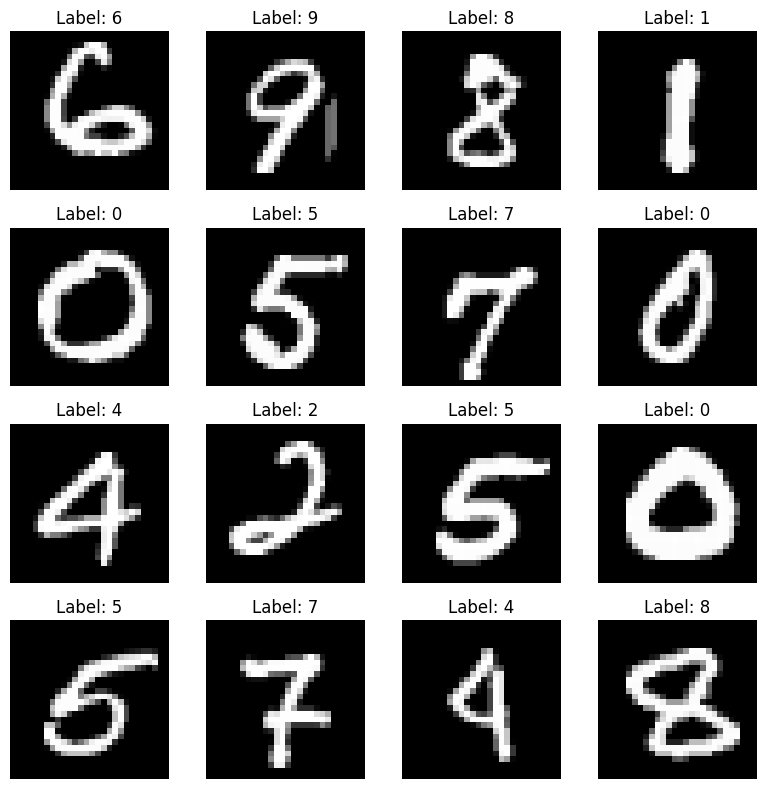

In [2]:
sys.path.append(os.path.abspath(".."))
from src.data_prep import load_mnist_data

# Load dataset using our helper function
X_train, X_test, y_train, y_test = load_mnist_data()

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Visualize some digits
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_train[i].reshape(28,28), cmap="gray")
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [54]:
from src.data_io import save_raw_data

# # Download raw data
# (X_train, y_train), (X_test, y_test) = mnist.load_data()

# Save raw
save_raw_data(X_train, y_train, X_test, y_test)


print("✅ Raw and processed datasets saved to data/ folder")


✅ Raw and processed datasets saved to data/ folder


## Step 2: Data Augmentation

To increase dataset complexity and make our models more robust, 
we apply image transformations such as rotation, shifting, shearing, and zooming.  

This helps simulate real-world digit variations (e.g., rotated, shifted, or poorly written digits).


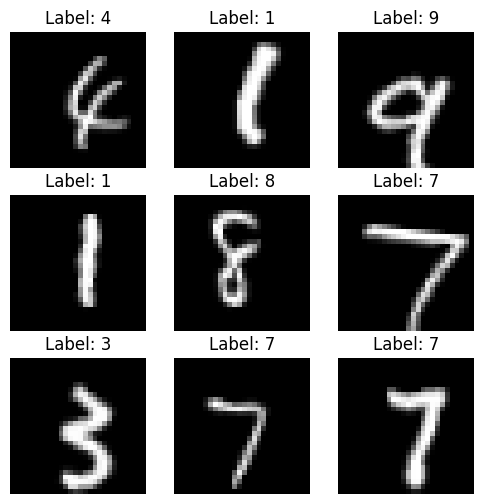

In [55]:
from src.data_prep import get_data_augmenter

# Example augmentation preview
datagen = get_data_augmenter()
X_train_img = X_train.reshape((-1, 28, 28, 1))

for X_batch, y_batch in datagen.flow(X_train_img, y_train, batch_size=9):
    plt.figure(figsize=(6,6))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(X_batch[i].reshape(28,28), cmap='gray')
        plt.title(f"Label: {y_batch[i]}")
        plt.axis('off')
    plt.show()
    break

## Step 3: Data Cleaning

We check for:
- Missing values (NaNs)
- Normalizing pixel values (0–1 range)


In [56]:
from src.data_prep import clean_data

X_train, X_test = clean_data(X_train, X_test)
print("Data cleaned and normalized.")

Data cleaned and normalized.


In [57]:
from src.data_io import save_processed_data

# Save processed data
save_processed_data(X_train, X_test, y_train, y_test)
print("Processed Data saved")

Processed Data saved


## Step 4: Binary Classification

We will train a simple classifier to predict whether a digit is "5" or not.  

Steps:
1. Convert the target labels to binary (5 vs not-5)
2. Train a classifier (we’ll use `SGDClassifier` for simplicity)
3. Make predictions on the test set
4. Evaluate with basic accuracy

In [5]:
from src.binary_classifier import train_binary_classifier, predict_binary

# Train classifier
clf = train_binary_classifier(X_train, y_train)

# Predict on test set
y_test_5 = (y_test == 5)
y_pred = predict_binary(clf, X_test)

# Quick accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_5, y_pred)
print(f"Binary classifier accuracy: {acc:.4f}")


Binary classifier accuracy: 0.9680


 Insights
- The binary classifier achieved **96.8% accuracy**, which means it predicts correctly about 97 out of 100 samples.  
- Accuracy alone can be misleading if the dataset is imbalanced (e.g., 90% class A, 10% class B). To confirm robustness, we should look at:
  - **Confusion Matrix**: See how well the model separates positive vs. negative classes.
  - **Precision & Recall**: Important when the cost of false positives or false negatives is high.
  - **ROC Curve & AUC**: Measures how well the model distinguishes between the two classes across thresholds.
- The high accuracy suggests the model has learned strong discriminative features, but we need to check for **overfitting** by comparing training vs. validation loss/accuracy.


## Step 5: Performance Measures

For binary classification:
- Confusion matrix
- Precision, recall, F1
- ROC curve & AUC
- Precision/Recall tradeoff


Confusion Matrix:
 [[8882  216]
 [ 104  798]]
Precision: 0.7870, Recall: 0.8847, F1-score: 0.8330


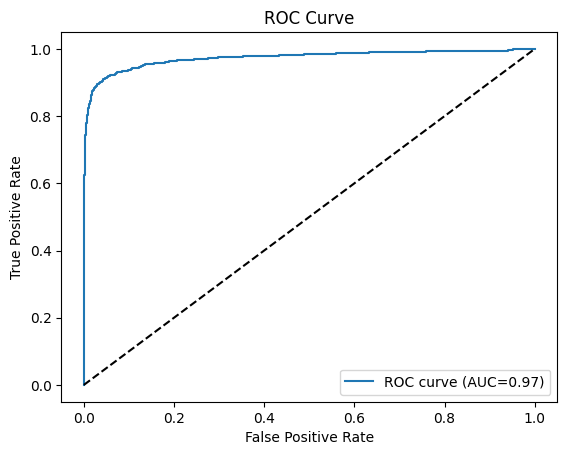

In [6]:
from src.evaluation import evaluate_binary, plot_roc_curve

cm, precision, recall, f1 = evaluate_binary(y_test_5, y_pred)
print("Confusion Matrix:\n", cm)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# For ROC, we need decision scores
y_scores = clf.decision_function(X_test)
plot_roc_curve(y_test_5, y_scores)


Performance Insights on Binary Classification

- **Overall Accuracy:** 96.8% — strong performance, but accuracy alone can hide imbalances.  
- **ROC AUC:** 0.97 — the model distinguishes well between the two classes across thresholds, which confirms its discriminative power.  

Error Distribution
- **Confusion Matrix:**  
  - True Negatives (8882) → Most of the "non-target" digits are correctly identified.  
  - False Positives (216) → Some "non-target" digits are mistakenly predicted as the target class.  
  - False Negatives (104) → A smaller number of target digits are missed.  
  - True Positives (798) → The majority of target digits are correctly classified.  

Precision & Recall Trade-off
- **Precision (0.787):** When the model predicts "positive," it is correct ~79% of the time.  
- **Recall (0.885):** The model captures ~88% of all true positives — so it's good at finding the target digit.  
- **F1-score (0.833):** A balanced score between precision and recall, showing the model performs well overall.  

Takeaways
- The model is slightly more **recall-oriented** (better at finding positives, even if some false alarms occur).  
- This trade-off is acceptable in tasks where **missing a target** (false negative) is more costly than a false positive.  
- To improve **precision** further, one could:
  - Adjust the decision threshold (e.g., >0.6 instead of >0.5).  
  - Use more advanced architectures (CNNs handle image data better than simple dense models).  
  - Apply targeted data augmentation to reduce confusion with similar-looking digits.  


## Step 6: Multi-class Classification

So far, we trained a binary classifier to distinguish between digit "5" and "not 5".
Now, we extend the task to a **multi-class classification** problem where the model predicts which digit (0–9) the image represents.

We will:
1. Train a multi-class classifier using `SGDClassifier` and `RandomForestClassifier`.
2. Evaluate performance using accuracy, confusion matrix, and classification report.
3. Visualize the confusion matrix to see where the model m


In [7]:
sys.path.append(os.path.abspath("src"))

from src.multiclass_classifier import train_sgd_classifier, train_rf_classifier, evaluate_classifier, predict_multiclass
import matplotlib.pyplot as plt
import seaborn as sns

# Train SGDClassifier
sgd_clf = train_sgd_classifier(X_train, y_train)
sgd_acc, sgd_cm, sgd_report = evaluate_classifier(sgd_clf, X_test, y_test)

print("SGD Classifier Accuracy:", sgd_acc)
print(sgd_report)

# Train RandomForestClassifier
rf_clf = train_rf_classifier(X_train, y_train)
rf_acc, rf_cm, rf_report = evaluate_classifier(rf_clf, X_test, y_test)

print("Random Forest Accuracy:", rf_acc)
print(rf_report)


SGD Classifier Accuracy: 0.91
              precision    recall  f1-score   support

           0      0.958     0.971     0.964       986
           1      0.951     0.978     0.964      1125
           2      0.935     0.875     0.904       999
           3      0.919     0.847     0.882      1020
           4      0.970     0.857     0.910       975
           5      0.829     0.896     0.861       902
           6      0.939     0.957     0.948       982
           7      0.883     0.961     0.920      1042
           8      0.857     0.869     0.863       975
           9      0.864     0.878     0.871       994

    accuracy                          0.910     10000
   macro avg      0.911     0.909     0.909     10000
weighted avg      0.912     0.910     0.910     10000

Random Forest Accuracy: 0.9685
              precision    recall  f1-score   support

           0      0.978     0.990     0.984       986
           1      0.986     0.986     0.986      1125
           2     

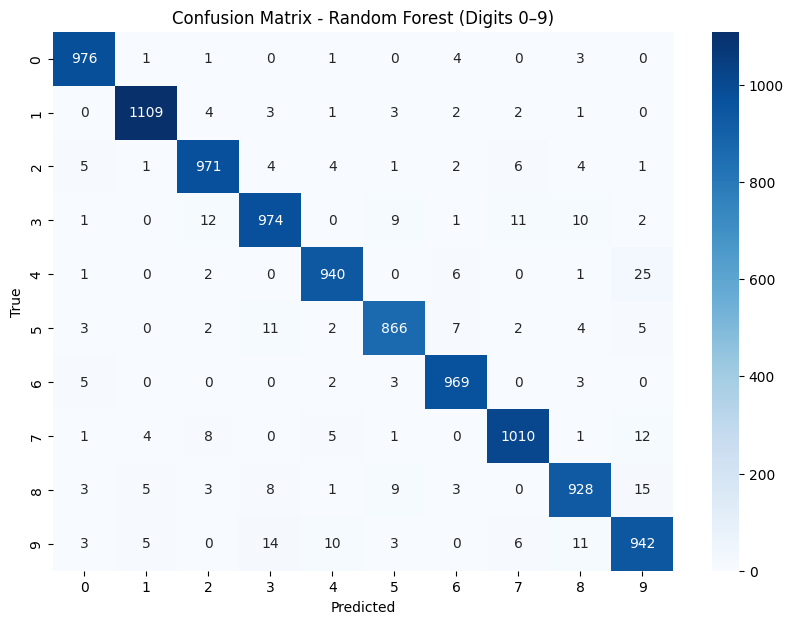

In [33]:
# Visualize confusion matrix for Random Forest
plt.figure(figsize=(10, 7))
sns.heatmap(rf_cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Random Forest (Digits 0–9)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

SGD vs Random Forest → RF clearly outperforms SGD (97% vs 91%).

Class-level difficulty → Digits 5, 8, 9 tend to have lower precision/recall → worth deeper error analysis (Step 7).

Confusion Matrix → A great tool to see which digits the model confuses most.

## Step 7: Error Analysis

Now that we trained our multiclass classifiers (SGD, RandomForest, etc.), 
we want to analyze **where the model is making mistakes**.

This step involves:
- Plotting the **confusion matrix** to see class-level errors.
- Visualizing **misclassified images** to get intuition about failure modes.


In [10]:
import os, sys
sys.path.append(os.path.join(".."))  # make sure src/ is visible

from src.data_prep import load_mnist_data
from src.multiclass_classifier import train_sgd_classifier, predict_multiclass
from src.error_analysis import plot_confusion_matrix, show_misclassified_images

# Load dataset
# X_train, X_test, y_train, y_test = load_mnist_data()

# Train a model (SGD here)
sgd_clf = train_sgd_classifier(X_train, y_train)

# Predictions
y_pred = predict_multiclass(sgd_clf, X_test)

# Class names (digits 0–9)
class_names = [str(i) for i in range(10)]


Confusion Matrix

The confusion matrix shows us where the model makes mistakes.  
Each row corresponds to the **true class**, and each column to the **predicted class**.


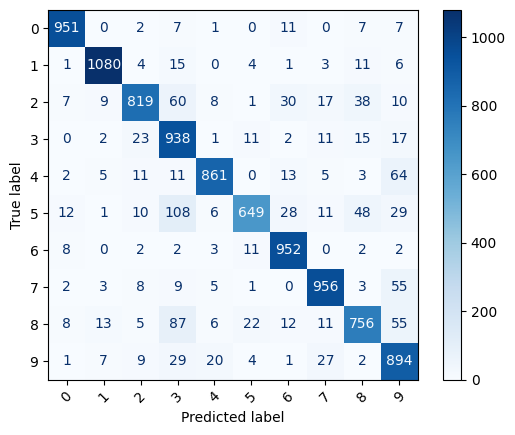

In [31]:
plot_confusion_matrix(y_test, y_pred, class_names)

Misclassified Samples

To understand *why* the model is making mistakes, we can visualize some misclassified images.
The plot below shows a sample of images where the true label ≠ predicted label.


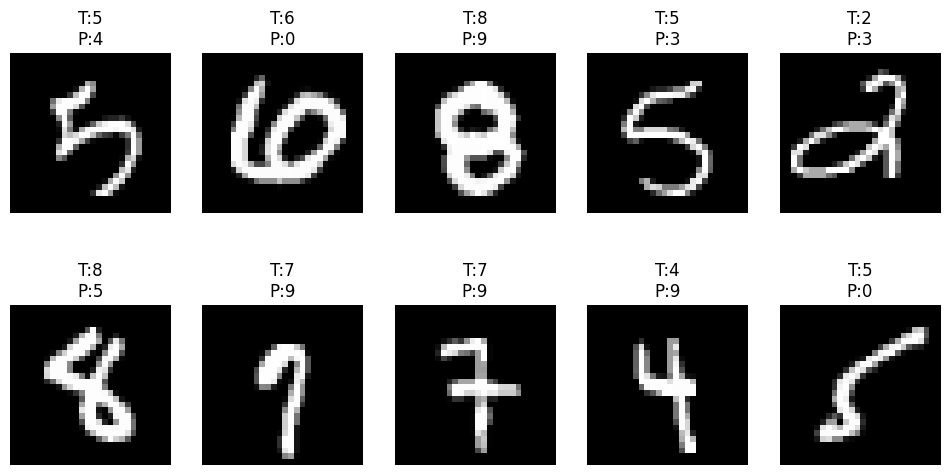

In [12]:
show_misclassified_images(X_test, y_test, y_pred, class_names, n_images=10)

## Step 8: Multi-label Classification

In this step, we transform MNIST into a **multi-label classification problem**.

- Instead of a single target (digit class), each image has **two labels**:
  1. Whether the digit is **greater or equal to 7**.
  2. Whether the digit is **odd**.

We’ll use a **K-Nearest Neighbors (KNN)** classifier, which works naturally for multi-label problems.


In [49]:
import os, sys
sys.path.append(os.path.join(".."))

from src.multilabel_classifier import train_multilabel_classifier, evaluate_multilabel_classifier, make_multilabel_targets, decode_bool_label

# # Load MNIST
# X_train, X_test, y_train, y_test = load_mnist_data()

# Train multilabel classifier
knn_clf = train_multilabel_classifier(X_train, y_train)

# Evaluate multilabel classifier
f1 = evaluate_multilabel_classifier(knn_clf, X_test, y_test)
print(f"Multi-label F1-score: {f1:.4f}")


Multi-label F1-score: 0.9790


Inspect Multi-label Predictions

Let’s test the model on a few samples and inspect whether it predicts correctly:

- First label: `is_large (>=7)`
- Second label: `is_odd`


In [44]:
# --- pick samples ---
n_samples = 10                       # change to how many thumbnails you want
idxs = np.random.choice(len(X_test), size=n_samples, replace=False)

X_sample = X_test[idxs]
y_true_digits = y_test[idxs]

# predictions (make sure knn_clf exists in the notebook)
y_pred_multi = knn_clf.predict(X_sample)   # shape (n_samples, 2) boolean/int

# compute true multi-labels for display (if you want to show them too)
y_true_multi = make_multilabel_targets(y_true_digits, ge_threshold=7)

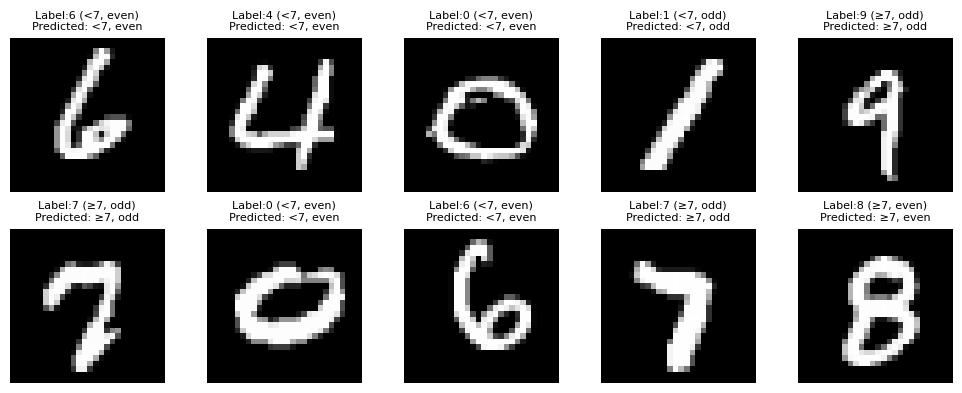

In [51]:
# --- plotting ---
cols = 5
rows = int(np.ceil(n_samples / cols))
plt.figure(figsize=(cols * 2, rows * 2))
for i, idx in enumerate(range(n_samples)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X_sample[i].reshape(28, 28), cmap="gray")
    true_digit = int(y_true_digits[i])
    true_txt = decode_bool_label(y_true_multi[i], ge_threshold=7)
    pred_txt = decode_bool_label(y_pred_multi[i], ge_threshold=7)
    plt.title(f"Label:{true_digit} ({true_txt})\nPredicted: {pred_txt}", fontsize=8)
    plt.axis("off")
plt.tight_layout()

## Step 9: Multi-output Classification

In this step, we extend MNIST into a **multi-output classification problem**.

- Each digit image is represented by 784 pixel values (28x28).
- We add random noise to images to simulate corrupted inputs.
- The task: predict the **clean digit image** from the noisy input.

This is a **multi-output classification** problem because the model predicts multiple targets (one per pixel).


In [16]:
import os, sys
sys.path.append(os.path.join(".."))

import matplotlib.pyplot as plt
import numpy as np


from src.multioutput_classifier import add_noise, train_multioutput_classifier, denoise_image


# Add noise
X_train_noisy = add_noise(X_train, noise_factor=100)
X_test_noisy = add_noise(X_test, noise_factor=100)


In [18]:
X_train_noisy[:10]

array([[14, 60, 84, ...,  0, 76, 21],
       [58, 32, 89, ..., 87, 25,  9],
       [54, 87,  3, ..., 68, 89,  3],
       ...,
       [60, 79, 23, ..., 12, 87, 61],
       [20, 43,  0, ..., 18,  1, 91],
       [ 6, 51,  7, ...,  6,  5, 90]], shape=(10, 784))

Train Multi-output Classifier

We’ll use **KNeighborsClassifier** to map noisy images → clean images.


In [17]:
knn_multioutput = train_multioutput_classifier(X_train_noisy, X_train)  # notice: targets are the clean images

Test on Noisy Images

Let’s denoise a few samples to see how well the model restores them.

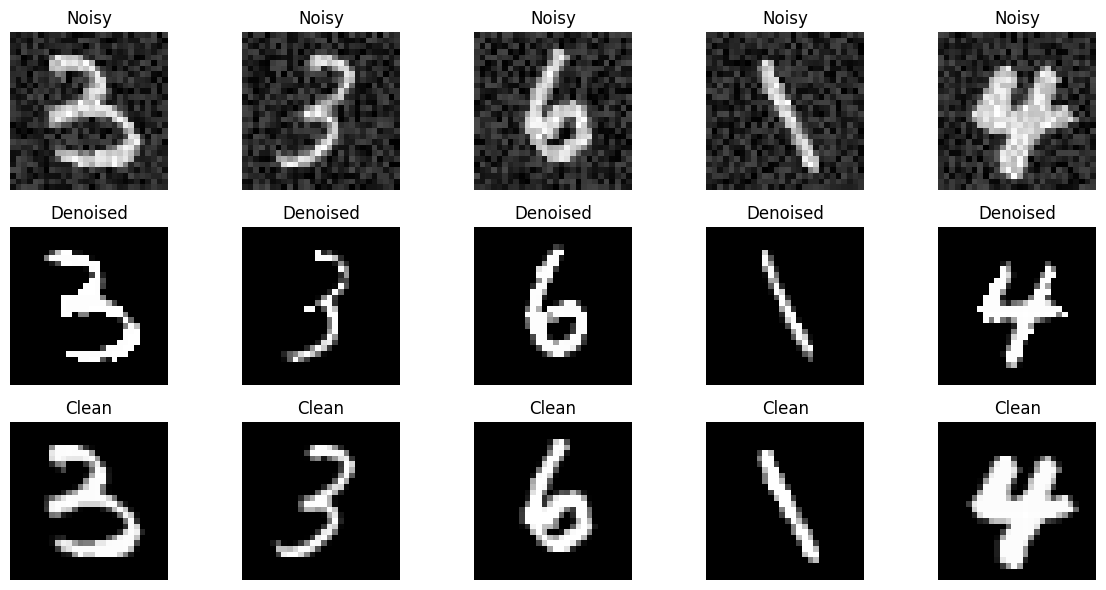

In [19]:
n_samples = 5
idxs = np.random.randint(0, len(X_test_noisy), n_samples)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(idxs):
    noisy_img = X_test_noisy[idx]
    clean_img = X_test[idx]
    denoised_img = denoise_image(knn_multioutput, noisy_img)

    # Plot noisy
    plt.subplot(3, n_samples, i+1)
    plt.imshow(noisy_img.reshape(28, 28), cmap="gray")
    plt.title("Noisy")
    plt.axis("off")

    # Plot denoised
    plt.subplot(3, n_samples, i+1+n_samples)
    plt.imshow(denoised_img.reshape(28, 28), cmap="gray")
    plt.title("Denoised")
    plt.axis("off")

    # Plot clean
    plt.subplot(3, n_samples, i+1+2*n_samples)
    plt.imshow(clean_img.reshape(28, 28), cmap="gray")
    plt.title("Clean")
    plt.axis("off")

plt.tight_layout()
plt.show()
